# Unified API: Train and evaluation

This notebook presents the solution for training and evaluating both the __GANITE__ and __CMGP__ algorithms over the [Twins](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/data/twins/) dataset, using a unified API.

For details about each algorithm, please refer to their dedicated notebooks:
 - [GANITE(Tensorflow) notebook](https://github.com/bcebere/ite-api/blob/main/notebooks/ganite_train_evaluation.ipynb).
 - [GANITE(PyTorch) notebook](https://github.com/bcebere/ite-api/blob/main/notebooks/ganite_pytorch_train_evaluation.ipynb).
 - [CMGP notebook](https://github.com/bcebere/ite-api/blob/main/notebooks/cmgp_train_evaluation.ipynb).

## Setup

First, make sure that all the depends are installed in the current environment.
```
pip install -r requirements.txt
pip install .
```

Next, we import all the dependencies necessary for the task.

In [1]:
# Double check that we are using the correct interpreter.
import sys
print(sys.executable)

# Import depends
from ite.algs.model import Model # the unified API
import ite.datasets as ds

from matplotlib import pyplot as plt
from IPython.display import HTML, display
import tabulate


/home/bcebere/anaconda3/envs/cambridge/bin/python
Instructions for updating:
non-resource variables are not supported in the long term


## Load the Dataset

The example is done using the [Twins](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/data/twins/) dataset.

Next, we load the dataset, process the data, and sample a training set and a test set.

The logic is implemented [here](https://github.com/bcebere/ite-api/tree/main/src/ite/datasets), and it adapted from the original [GANITE pre-processing implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/ganite/data_preprocessing_ganite.py).

For CGMP, we have to downsample to 1000 training items. For the rest, we load without downsampling.

In [2]:
train_ratio = 0.8
 
full_dataloader = ds.load("twins", train_ratio)
cmgp_dataloader = ds.load("twins", train_ratio, downsample=1000)

## Load and train GANITE(Tensorflow version)

The constructor requires the name of the chosen algorithm for the first parameter - `GANITE`.

The constructor supports the same parameters as the "native" version:
 - `dim`: The number of features in X.
 - `dim_outcome`: The number of potential outcomes.
 - `dim_hidden`: hyperparameter for tuning the size of the hidden layer.
 - `depth`: hyperparameter for the number of hidden layers in the generator and inference blocks.
 - `num_iterations`: hyperparameter for the number of training epochs.
 - `alpha`: hyperparameter used for the Generator block loss.
 - `beta`: hyperparameter used for the ITE block loss.
 - `num_discr_iterations`: number of iterations executed by the discriminator.
 
 The hyperparameters used in this experiment are from Table 7 in the paper.

100%|██████████| 10000/10000 [00:13<00:00, 764.22it/s]


Counterfactual Block:
 - Discriminator loss: 0.687 +/- 0.006
 - Generator loss: -1.342 +/- 0.029
ITE Block:
 - Loss: 0.254 +/- 0.027
ITE Block in-sample metrics:
 - sqrt_PEHE: 0.294 +/- 0.000
 - ATE: 0.015 +/- 0.001
 - MSE: 0.085 +/- 0.007
ITE Block out-sample metrics:
 - sqrt_PEHE: 0.283 +/- 0.000
 - ATE: 0.018 +/- 0.001
 - MSE: 0.081 +/- 0.007


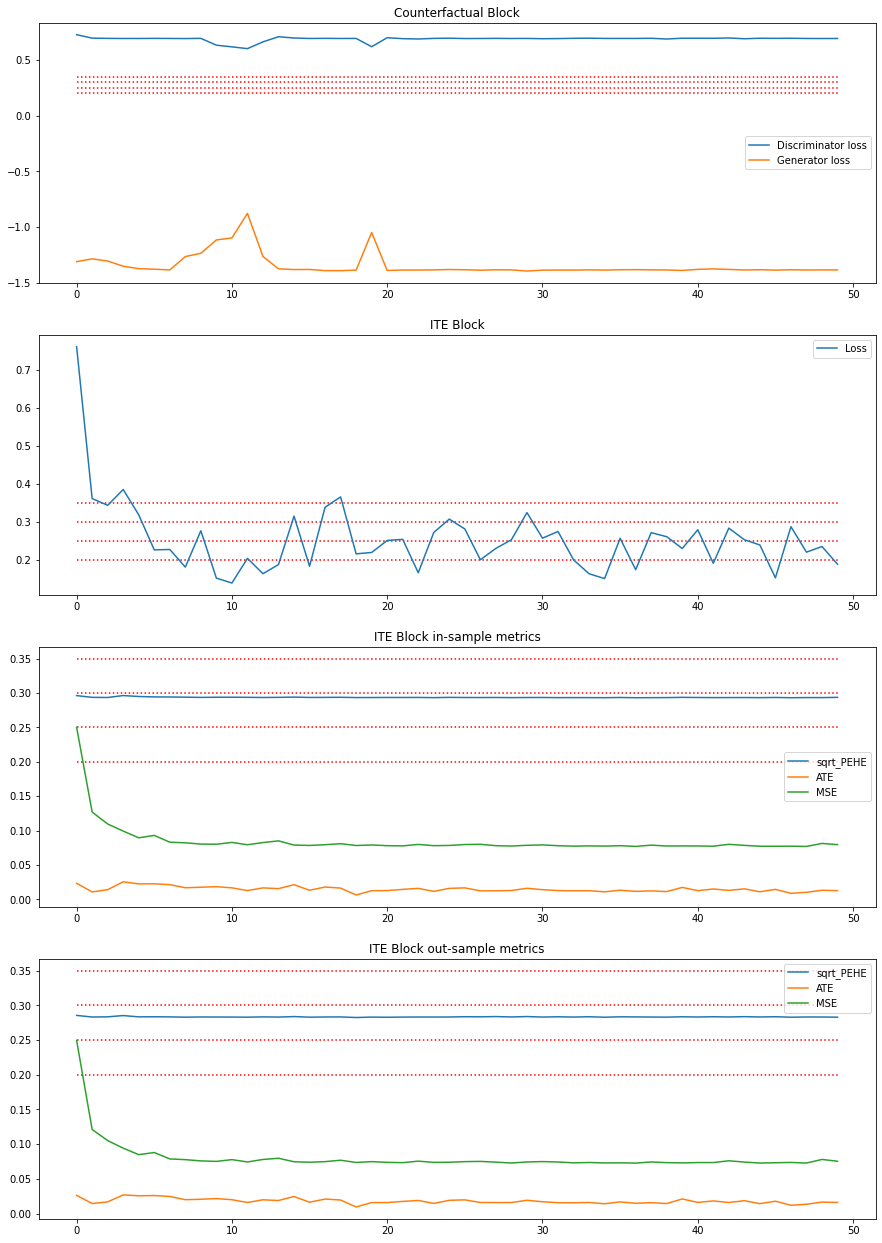

In [3]:
dim = len(full_dataloader[0][0])
dim_outcome = full_dataloader[-1].shape[1]
 
ganite_model = Model(
    "GANITE",
    dim, 
    dim_outcome, 
    dim_hidden=8, 
    num_iterations=10000, 
    alpha=2, 
    beta=2, 
    minibatch_size=128, 
    num_discr_iterations=3, 
    depth=5,
)

ganite_tf_metrics = ganite_model.train(*full_dataloader)
ganite_tf_metrics.print()

ganite_tf_metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

## Load and train GANITE(PyTorch version)

The constructor requires the name of the chosen algorithm for the first parameter - `GANITE_TORCH`.

The constructor supports the same parameters as the "native" version:
 - `dim`: The number of features in X.
 - `dim_outcome`: The number of potential outcomes.
 - `dim_hidden`: hyperparameter for tuning the size of the hidden layer.
 - `depth`: hyperparameter for the number of hidden layers in the generator and inference blocks.
 - `num_iterations`: hyperparameter for the number of training epochs.
 - `alpha`: hyperparameter used for the Generator block loss.
 - `beta`: hyperparameter used for the ITE block loss.
 - `num_discr_iterations`: number of iterations executed by the discriminator.
 
 The hyperparameters used in this experiment are computed using the [hyperparameter tuning notebook](https://github.com/bcebere/ite-api/blob/main/notebooks/hyperparam_tuning.ipynb).

100%|██████████| 3000/3000 [00:30<00:00, 99.90it/s] 


Counterfactual Block:
 - Discriminator loss: 0.693 +/- 0.000
 - Generator loss: -0.671 +/- 0.035
ITE Block:
 - ITE loss: 0.973 +/- 0.261
ITE Block in-sample metrics:
 - sqrt_PEHE: 0.294 +/- 0.000
 - ATE: 0.017 +/- 0.003
 - MSE: 0.091 +/- 0.023
ITE Block out-sample metrics:
 - sqrt_PEHE: 0.283 +/- 0.000
 - ATE: 0.020 +/- 0.003
 - MSE: 0.087 +/- 0.024


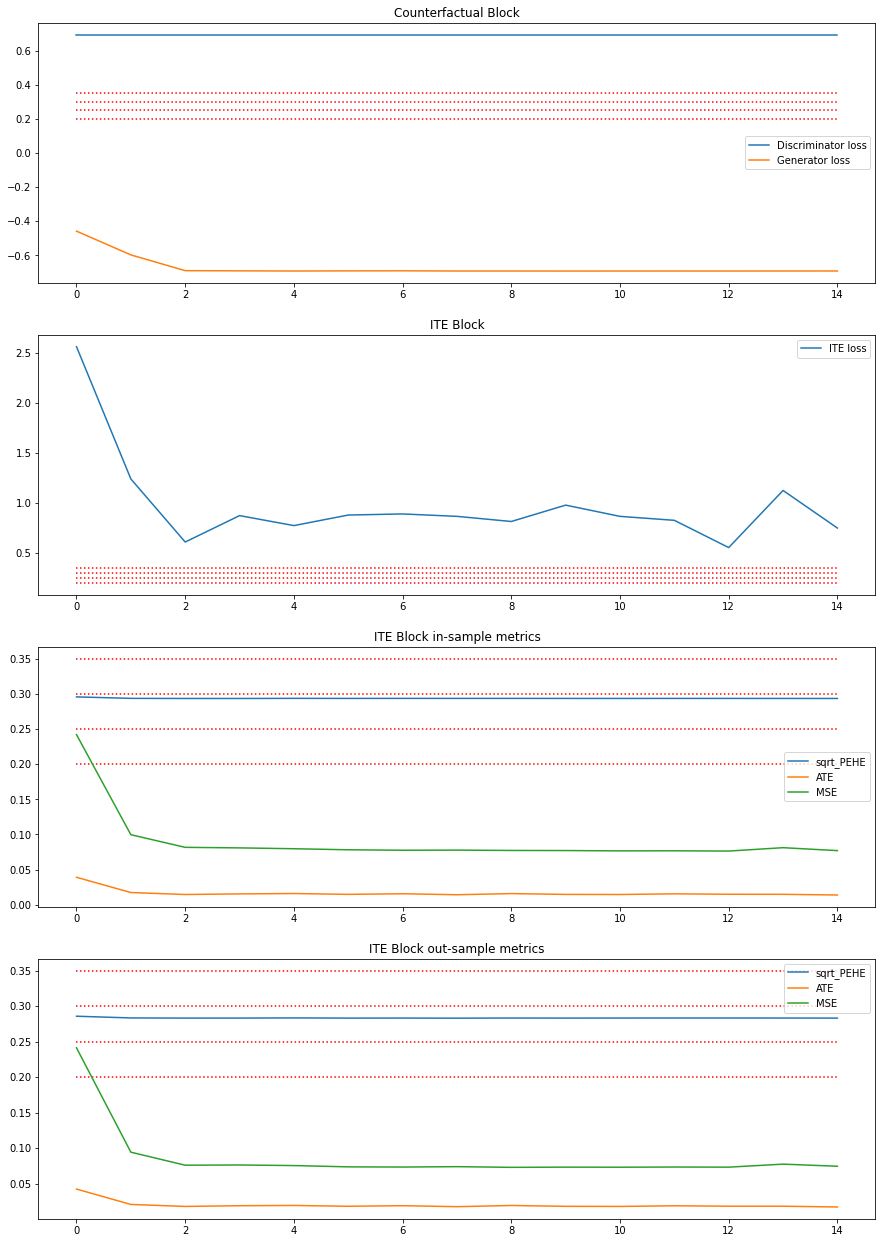

In [4]:
ganite_torch_model = Model(
    "GANITE_TORCH",
    dim, 
    dim_outcome, 
    dim_hidden=30,
    num_iterations=3000,
    alpha=1,
    beta=10,
    minibatch_size=256,
    num_discr_iterations=6,
    depth=5,
)

ganite_torch_metrics = ganite_torch_model.train(*full_dataloader)
ganite_torch_metrics.print()

ganite_torch_metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

## Load and train CMGP

The constructor requires the name of the chosen algorithm for the first parameter - `CMGP`.

The constructor supports the following parameters:
 - `dim`: The number of features in X.
 - `dim_outcome`: The number of potential outcomes.
 - `max_gp_iterations`: Maximum number of GP iterations before stopping the training.
 

 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


in-sample metrics:
 - sqrt_PEHE: 0.298 +/- 0.015
 - ATE: 0.014 +/- 0.013
 - MSE: 0.073 +/- 0.007
out-sample metrics:
 - sqrt_PEHE: 0.291 +/- 0.015
 - ATE: 0.018 +/- 0.021
 - MSE: 0.018 +/- 0.021


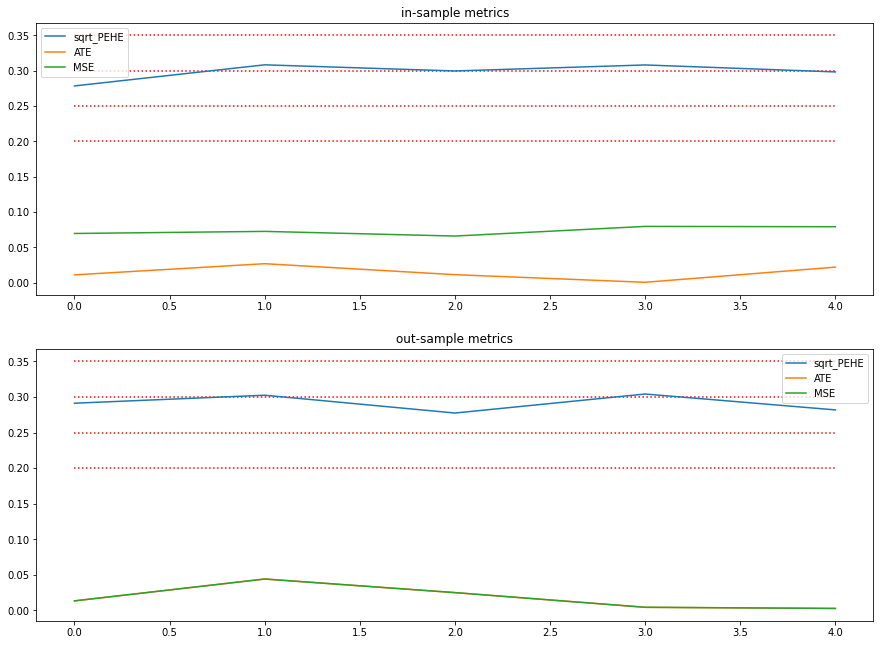

In [5]:
cmgp_model = Model(
    "CMGP",
    dim=dim,
    dim_outcome=dim_outcome,
    max_gp_iterations=1000, # (optional) Maximum number of interations for the Gaussian Process
)

for experiment in range(5):
    cmgp_dataloader = ds.load("twins", train_ratio, downsample=1000)
    cmgp_metrics = cmgp_model.train(*cmgp_dataloader)

cmgp_metrics.print()

cmgp_metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

## Evaluate the models on the test set

We evaluate each algorithm on their test sets, using the [PEHE](https://github.com/bcebere/ite-api/blob/main/src/ite/utils/numpy.py#L19) and [ATE](https://github.com/bcebere/ite-api/blob/main/src/ite/utils/numpy.py#L58) metrics.

In [9]:
for scenario in ["in-sample", "out-sample"]:
    print(f"{scenario} metrics:")

    results = [
        [
            "GANITE",
            "{:0.3f} +/- {:0.3f}".format(
                *ganite_tf_metrics.mean_confidence_interval("sqrt_PEHE", f"ITE Block {scenario} metrics")
            ),
            "{:0.3f} +/- {:0.3f}".format(
                *ganite_tf_metrics.mean_confidence_interval("ATE", f"ITE Block {scenario} metrics")
            ),
            "{:0.3f} +/- {:0.3f}".format(
                *ganite_tf_metrics.mean_confidence_interval("MSE", f"ITE Block {scenario} metrics")
            ),
        ],
        [
            "GANITE_TORCH",
            "{:0.3f} +/- {:0.3f}".format(
                *ganite_torch_metrics.mean_confidence_interval("sqrt_PEHE", f"ITE Block {scenario} metrics")
            ),
            "{:0.3f} +/- {:0.3f}".format(
                *ganite_torch_metrics.mean_confidence_interval("ATE", f"ITE Block {scenario} metrics")
            ),
            "{:0.3f} +/- {:0.3f}".format(
                *ganite_torch_metrics.mean_confidence_interval("MSE", f"ITE Block {scenario} metrics")
            ),
        ],
        [
            "CMGP",
            "{:0.3f} +/- {:0.3f}".format(
                *cmgp_metrics.mean_confidence_interval("sqrt_PEHE", f"{scenario} metrics")
            ),
            "{:0.3f} +/- {:0.3f}".format(*cmgp_metrics.mean_confidence_interval("ATE", f"{scenario} metrics")),
            "{:0.3f} +/- {:0.3f}".format(*cmgp_metrics.mean_confidence_interval("MSE", f"{scenario} metrics")),
        ],
    ]

    display(
        HTML(tabulate.tabulate(results, headers=["Model", "sqrt_PEHE", "ATE", "MSE"], tablefmt="html"))
    )

in-sample metrics:


Model,sqrt_PEHE,ATE,MSE
GANITE,0.294 +/- 0.000,0.015 +/- 0.001,0.085 +/- 0.007
GANITE_TORCH,0.294 +/- 0.000,0.017 +/- 0.003,0.091 +/- 0.023
CMGP,0.298 +/- 0.015,0.014 +/- 0.013,0.073 +/- 0.007


out-sample metrics:


Model,sqrt_PEHE,ATE,MSE
GANITE,0.283 +/- 0.000,0.018 +/- 0.001,0.081 +/- 0.007
GANITE_TORCH,0.283 +/- 0.000,0.020 +/- 0.003,0.087 +/- 0.024
CMGP,0.291 +/- 0.015,0.018 +/- 0.021,0.018 +/- 0.021


## References

1. Jinsung Yoon, James Jordon, Mihaela van der Schaar, "GANITE: Estimation of Individualized Treatment Effects using Generative Adversarial Nets", International Conference on Learning Representations (ICLR), 2018 ([Paper](https://openreview.net/forum?id=ByKWUeWA-)).
2. [GANITE Reference implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/ganite/).
3. Ahmed M. Alaa, Mihaela van der Schaar, "Bayesian Inference of Individualized Treatment
Effects using Multi-task Gaussian Processes", NeurIPS, 2017 ([Paper](https://arxiv.org/pdf/1704.02801.pdf)).
4. [CMGP Reference implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/causal_multitask_gaussian_processes_ite/).
5. [Clairvoyance: a Unified, End-to-End AutoML Pipeline for Medical Time Series](https://github.com/vanderschaarlab/clairvoyance).